In [1]:
import numpy as np
from scipy import stats
from scipy import constants

import matplotlib.pyplot as plt
%matplotlib inline

1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

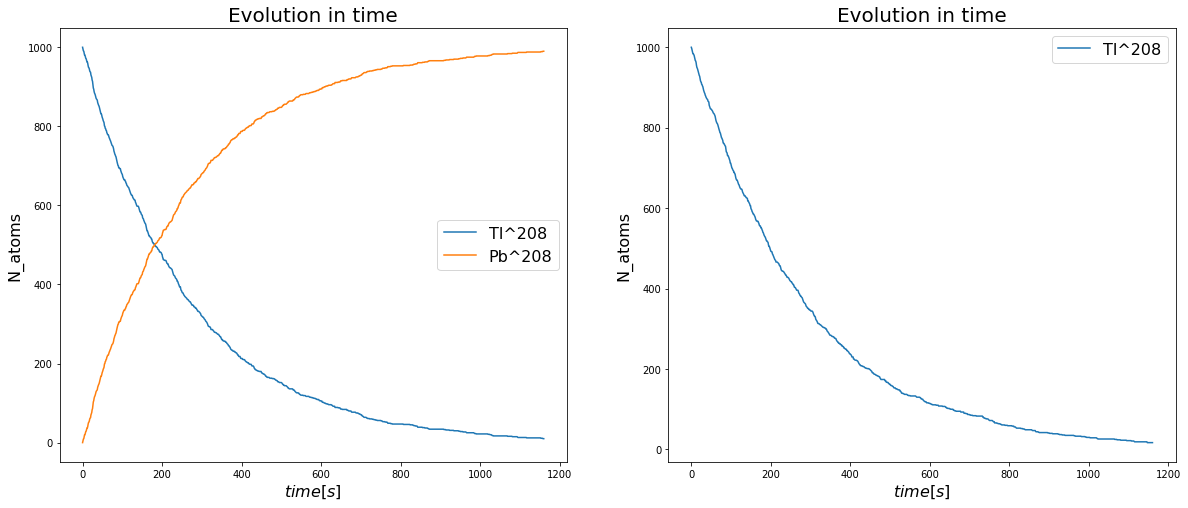

In [2]:
half_l = 3.052*60 

N0_Tl = 1000


def p_decay(time):
    return 1 - 2**(-time/half_l)

t0=0
tf=6.345*half_l
t = range(t0 , int(tf) , 1)

Nt_Tl=[]
Nt_Tl.append(N0_Tl)

n=np.random.rand(N0_Tl)


for time in t[1:]:
    Nt_Tl.append(N0_Tl - len(n[ n < p_decay(time)]))
    

fig , ax = plt.subplots(1 , 2 , figsize=(20,8))

ax[0].set_title("Evolution in time" , fontsize=20)

ax[0].plot(t , Nt_Tl , label="Tl^208")
ax[0].plot(t , N0_Tl - np.array(Nt_Tl), label="Pb^208" , color ='C1')

ax[0].set_ylabel("N_atoms" , fontsize=16)
ax[0].set_xlabel("$time [s]$" , fontsize=16)
ax[0].legend(fontsize=16)




#part 2

def expon_pdf(x, mu=np.log(2)/half_l):
    """PDF of exponential distribution."""
    return mu*np.exp(-mu*x)


def expon_icdf(z, mu=np.log(2)/half_l):
    """Inverse CDF of exponential distribution - i.e. quantile function."""
    return -np.log(1-z)/mu


u = np.random.uniform(0, 1, N0_Tl)
v = expon_icdf(u)

Nt_Tl = []
Nt_Tl.append(N0_Tl)

for time in t[1:]:
    Nt_Tl.append(N0_Tl - len(v[v < time]))
    

ax[1].set_title("Evolution in time" , fontsize=20)

ax[1].plot(t , Nt_Tl , label="Tl^208")
#ax[1].plot(t, expon_pdf(t) , c='C1')

ax[1].set_ylabel("N_atoms" , fontsize=16)
ax[1].set_xlabel("$time [s]$" , fontsize=16)
ax[1].legend(fontsize=16)



2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

The fraction of the 𝛼 particles that backscatter ( 𝜃 > 𝜋/2 ) is 0.1577 %
The particles that bounce-back are 1577 over 1e6


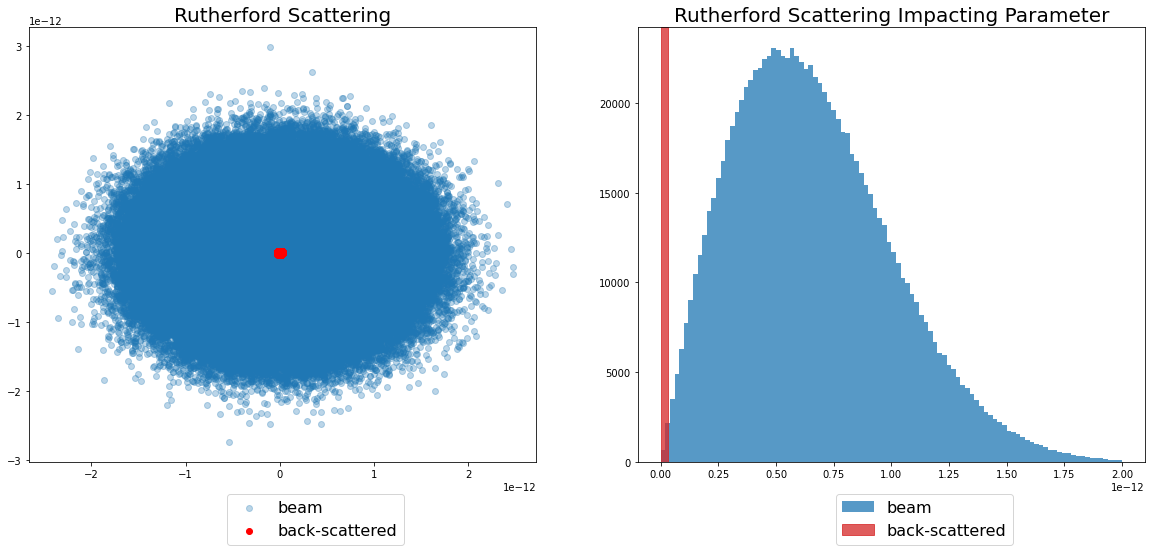

In [43]:
e = constants.elementary_charge
e0 = constants.epsilon_0
a0 = (4*np.pi*e0*(constants.hbar**2))/(constants.m_e*(e**2))

def theta(b , Z , E):
    return 2*np.arctan((Z*e**2)/(2*np.pi*e0*E*b))
    
    
E = 7.7e6*e
Z = 79
N_part = 1e6


#defining the beam
mu   = [0,0]
cov  = np.eye(2)*(a0/100)**2
beam = np.random.multivariate_normal(mu, cov, int(N_part)).T


#bouncing-back particles
b = np.sqrt(np.sum(beam**2 , axis=0))
scattering_angle = theta(b, Z, E)

back_part = scattering_angle[scattering_angle > np.pi/2]

print("The fraction of the 𝛼 particles that backscatter ( 𝜃 > 𝜋/2 ) is %2.4f %%" %(len(back_part)*100/N_part))
print("The particles that bounce-back are %4.0f over 1e6" %(len(back_part)) )


# plots 

b_beam = [beam[0][scattering_angle > (np.pi/2) ], beam[1][scattering_angle > (np.pi/2)]]


fig , ax = plt.subplots(1 , 2 , figsize=(20,8))

ax[0].set_title("Rutherford Scattering" , fontsize=20)

ax[0].scatter(beam[0], beam[1], label='beam', alpha=0.3)
ax[0].scatter(b_beam[0], b_beam[1], label='back-scattered' , c='r')
ax[0].legend(loc=(0.39,-0.19) , fontsize=16)


ax[1].set_title("Rutherford Scattering Impacting Parameter" , fontsize=20)
ax[1].hist(b, bins=100, range=[0, 2e-12], label='beam', alpha=0.75)
ax[1].axvspan(b[scattering_angle>np.pi/2].min(), b[scattering_angle>np.pi/2].max(), alpha=0.75, label='back-scattered' , color='tab:red')
ax[1].legend(loc=(0.39,-0.19) , fontsize=16)


3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

In [54]:
def f(x):
    return (np.sin(1/(x*(2-x))))**2
                  
# hit/miss method
N = int(1e6)
count=0

for i in range(N):
    x=np.random.uniform(0,2)
    y=np.random.random()
    if y<f(x): count+=1
        
I=2*count/N

p = count/N
err_I = 2*np.sqrt(N*p*(1-p))/N  #following binomial distribution
print("The value of the Integral of f(x) with hit/miss method = %3.6f +- %3.6f"%(I, err_I))


# mean value method
x = np.linspace(0.001, 1.999, N)
I = (2/N)*np.sum(f(x))
err_I = 2*np.sqrt((np.sum(f(x)**2)/N-np.sum(f(x)/N)**2)/N)
print("The value of the Integral of f(x) with mean value method = %3.6f +- %3.6f"%(I, err_I))

The value of the Integral of f(x) with hit/miss method = 1.451218 +- 0.000892
The value of the Integral of f(x) with mean value method = 1.451852 +- 0.000527


4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [59]:
def f(x):
    r_sq = np.sum(x**2 , axis=0)
    return np.array([1 if (r <= 1) else 0 for r in r_sq])

#2-dimensional

N = int(1e6)
x = np.random.uniform(-1,1,(2,N))
I = 2**2*np.sum(f(x))/N
err_I = 2*np.sqrt((np.sum(f(x)**2)/N-np.sum(f(x)/N)**2)/N)

print("The area of the unit radius circle in 2D is %3.6f +- %3.6f"%(I, err_I))


#10-dimensional

x = np.random.uniform(-1,1,(10,N))
I = 2**10*np.sum(f(x))/N
err_I = 2*np.sqrt((np.sum(f(x)**2)/N-np.sum(f(x)/N)**2)/N)

print("The area of the unit radius circle in 10D is %3.6f +- %3.6f"%(I, err_I))


The area of the unit radius circle in 2D is 3.143204 +- 0.000821
The area of the unit radius circle in 10D is 2.577408 +- 0.000100


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [49]:
def w(x):
    return 1/(np.sqrt(x))

def f(x):
    return (x**(-1/2) / (np.exp(x) +1))

N = int(1e4)
x = np.random.rand(N)**2

I = (2/N)*np.sum(f(x)/w(x))

print("The value of the Integral of f(x) is %3.4f" %I)

The value of the Integral of f(x) is 0.8408
